In [1]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def preprocessing_op(image_op, config):
    """
    Creates preprocessing operations that are going to be applied on a single frame.
    
    TODO: Customize for your needs.
    You can do any preprocessing (masking, normalization/scaling of inputs, augmentation, etc.) by using tensorflow operations.
    Built-in image operations: https://www.tensorflow.org/api_docs/python/tf/image 
    """
    with tf.name_scope("preprocessing"):
        # Reshape serialized image.
        image_op = tf.reshape(image_op, (config['img_height'], 
                               config['img_width'], 
                               config['img_num_channels'])
                          )
        # Integer to float.
        image_op = tf.to_float(image_op)
        
        # Normalize (zero-mean unit-variance) the image locally, i.e., by using statistics of the 
        # image not the whole data or sequence. 
        image_op = tf.image.per_image_standardization(image_op)
    
        return image_op

def read_and_decode_sequence(filename_queue, config):
    # Create a TFRecordReader.
    readerOptions = tf.python_io.TFRecordOptions(compression_type=tf.python_io.TFRecordCompressionType.GZIP)
    reader = tf.TFRecordReader(options=readerOptions)
    _, serialized_example = reader.read(filename_queue)
    
    # Read one sequence sample.
    # The training and validation files contains the following fields:
    # - label: label of the sequence which take values between 1 and 20.
    # - length: length of the sequence, i.e., number of frames.
    # - depth: sequence of depth images. [length x height x width x numChannels]
    # - rgb: sequence of rgb images. [length x height x width x numChannels]
    # - segmentation: sequence of segmentation maskes. [length x height x width x numChannels]
    # - skeleton: sequence of flattened skeleton joint positions. [length x numJoints]
    #
    # The test files doesn't contain "label" field.
    # [height, width, numChannels] = [80, 80, 3]
    with tf.name_scope("TFRecordDecoding"):
        context_encoded, sequence_encoded = tf.parse_single_sequence_example(
                serialized_example,
                # "label" and "lenght" are encoded as context features. 
                context_features={
                    "label": tf.FixedLenFeature([], dtype=tf.int64),
                    "length": tf.FixedLenFeature([], dtype=tf.int64)
                },
                # "depth", "rgb", "segmentation", "skeleton" are encoded as sequence features.
                sequence_features={
                    "depth": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "rgb": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "segmentation": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "skeleton": tf.FixedLenSequenceFeature([], dtype=tf.string),
                })

        # Fetch required data fields. 
        # TODO: Customize for your design. Assume that only the RGB images are used for now.
        # Decode the serialized RGB images.    
        seq_rgb = tf.decode_raw(sequence_encoded['rgb'], tf.uint8)
        seq_label = context_encoded['label']
        seq_len = context_encoded['length']
        # Output dimnesionality: [seq_len, height, width, numChannels]
        # tf.map_fn applies the preprocessing function on every image in the sequence, i.e., frame.
        seq_rgb = tf.map_fn(lambda x: preprocessing_op(x, config),
                                elems=seq_rgb,
                                dtype=tf.float32,
                                back_prop=False)
    
        return [seq_rgb, seq_label, seq_len]
    

def input_pipeline(filenames, config):
    with tf.name_scope("input_pipeline"):
        # Create a queue of TFRecord input files.
        filename_queue = tf.train.string_input_producer(filenames, num_epochs=config['num_epochs'], shuffle=True)
        # Read the data from TFRecord files, decode and create a list of data samples by using threads.
        sample_list = [read_and_decode_sequence(filename_queue, config) for _ in range(config['ip_num_read_threads'])]
        # Create batches.
        # Since the data consists of variable-length sequences, allow padding by setting dynamic_pad parameter.
        # "batch_join" creates batches of samples and pads the sequences w.r.t the max-length sequence in the batch.
        # Hence, the padded sequence length can be different for different batches.
        batch_rgb, batch_labels, batch_lens = tf.train.batch_join(sample_list,
                                                    batch_size=config['batch_size'],
                                                    capacity=config['ip_queue_capacity'],
                                                    enqueue_many=False,
                                                    dynamic_pad=True,
                                                    name="batch_join_and_pad")

        return batch_rgb, batch_labels, batch_lens

In [3]:
'''
A simple test routine:
'''
config = {}
config['img_height'] = 80
config['img_width'] = 80
config['img_num_channels'] = 3
config['num_epochs'] = 10
config['batch_size'] = 16
# Capacity of the queue which contains the samples read by data readers.
# Make sure that it has enough capacity.
config['ip_queue_capacity'] = config['batch_size']*10  
config['ip_num_read_threads'] = 6
# Directory of the data.
config['data_dir'] = "/home/eaksan/uie_data/train/"
# File naming
config['file_format'] = "dataTrain_%d.tfrecords"
# File IDs to be used for training.
config['file_ids'] = list(range(1,10))

# Create a list of TFRecord input files.
filenames = [os.path.join(config['data_dir'], config['file_format'] % i) for i in config['file_ids']]

# Create data loading operators. This will be represented as a node in the computational graph.
batch_samples_op, batch_labels_op, batch_seq_len_op = input_pipeline(filenames, config)
# TODO: batch_samples_op, batch_labels_op and batch_seq_len_op are like input placeholders. You can directly 
# feed them to your model.

# Create tensorflow session and initialize the variables (if any).
sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
sess.run(init_op)
# Create threads to prefetch the data.
# https://www.tensorflow.org/programmers_guide/reading_data#creating_threads_to_prefetch_using_queuerunner_objects
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

"""
# Training Loop
# The input pipeline creates input batches for config['num_epochs'] epochs,
# You can iterate over the training data by using coord.should_stop() signal.
try:
    while not coord.should_stop():
        # TODO: Model training
        
except tf.errors.OutOfRangeError:
    print('Done training for %d epochs, %d steps.' % (FLAGS.num_epochs, step))
finally:
    # When done, ask the threads to stop.
    coord.request_stop()

# Wait for threads to finish.
coord.join(threads)
# Close session
sess.close()
"""

In [6]:
# Fetch a batch of samples.
batch_samples, batch_labels, batch_seq_len = sess.run([batch_samples_op, batch_labels_op, batch_seq_len_op])

# Samples: 16
Sequence lengths: [ 69  68 107  71  84  72  73  79  86  70  73  79  73  76  76  69]
Sequence labels: [ 145  314  798  146 1217 1072  315  478  799 1218  147 1073  316 1219  479
  800]
Sequence type: <class 'numpy.ndarray'>
Sequence shape: (16, 107, 80, 80, 3)
Image shape: (80, 80, 3)


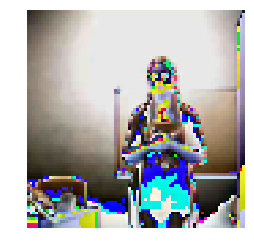

In [7]:
# Print 
print("# Samples: " + str(len(batch_samples)))
print("Sequence lengths: " + str(batch_seq_len))
print("Sequence labels: " + str(batch_labels))

# Note that the second dimension will give maximum-length in the batch, i.e., the padded sequence length.
print("Sequence type: " + str(type(batch_samples)))
print("Sequence shape: " + str(batch_samples.shape))

# Fetch first clips 11th frame.
img = batch_samples[0][10]
print("Image shape: " + str(img.shape))

plt.figure()
plt.axis("off")
plt.imshow(img) # Note that image may look wierd because it is normalized.